# Stacked Generalization (Stacking with Cross-Validation)

"Stacking with Cross-Validation"（CV 堆疊）是在 Stacking 方法的基礎上引入交叉驗證，以更好地估計模型性能並減少過度擬合的技術。它在訓練基本模型和元模型時，使用交叉驗證的方式來生成預測結果，從而更準確地進行模型融合。

## 步驟

CV 堆疊的基本步驟如下：

1. 基本模型層（第一層）：將訓練數據分成 K 個折疊（folds），每個折疊用於訓練基本模型。對於每個折疊，使用 K-1 個折疊的數據來訓練基本模型，然後在剩餘的折疊上生成預測結果。

2. 元模型層（第二層）：對於每個基本模型，使用它在未使用的折疊上生成的預測結果作為新的特徵。然後，使用完整的訓練數據集和交叉驗證的方式，訓練元模型。這樣做可以在更多的數據上進行訓練，並在不同的數據上進行驗證，以減少過度擬合。

<font size = 4 color = orange>stacking with CV 的實際方法似乎有很多種(?), 以下例子以有套件的方式為主.</font>

## 優缺點

### 優點：

* 更準確的性能估計：使用交叉驗證生成的預測結果，可以更準確地估計模型在未見數據上的性能，從而避免了對單一驗證集的依賴。

* 降低過度擬合風險：將訓練數據分成多個折疊，使得每個基本模型都在不同的數據子集上進行訓練，有助於減少過度擬合的風險。

* 更可靠的模型融合：使用交叉驗證生成的預測結果可以更好地捕捉數據的結構和差異，提高了元模型的泛化能力。

* 泛化能力較強：由於使用了多個不同的基本模型，並在多個數據子集上進行訓練，因此生成的元模型通常具有較強的泛化能力。

### 缺點：

* 複雜性和計算成本高：Stacking with Cross-Validation 需要在多個交叉驗證迭代中訓練基本模型和元模型，這增加了計算成本和時間。

* 參數調整困難：由於涉及多個模型的訓練和融合，需要調整多個模型的參數，以獲得最佳結果。這需要耗費額外的時間和努力。

* 過擬合風險：儘管交叉驗證有助於減少過度擬合，但如果設計不當或者模型複雜度過高，仍然存在過擬合的風險。

* 需大量數據：Stacking with Cross-Validation 需要足夠的數據以支持多次的交叉驗證迭代，因此在數據量較少時可能不適用。

## python_1

不使用套件

[參考網站](https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/)

流程簡述 :
假設有n筆資料, 使用 T 個 model
1. 使用 k-fold 去 fit base model. 再做每次 k-fold 時都會得到 y-pred, 其長度是 1/k 個 data, 把他和真實的 y 放到一個 matrix 中, 執行 k 次會得到由y-pred和y所組成的 n*(T+1) 的 matrix.
2. 使用剛剛得到的 n*(T+1) 的 matrix 去 fit meta model.
3. 重新用完整資料去fit base model, 得到 new base model

如果要預測新資料, 則放入new base model後得到 test y_pred, 再放入第二步得到的 meta model 即可.

In [64]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 5

# 載入數據集
iris = load_iris()
X, y = iris.data, iris.target

# 將數據分割成訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 創建基模型
base_model1 = KNeighborsClassifier(n_neighbors = 3)
base_model2 = RandomForestClassifier(random_state = RANDOM_SEED)
base_model3 = GaussianNB()

# 用交叉驗證的方式對基模型進行預測
y_pred_base1 = cross_val_predict(base_model1, X_train, y_train, cv=5)
y_pred_base2 = cross_val_predict(base_model2, X_train, y_train, cv=5)
y_pred_base3 = cross_val_predict(base_model3, X_train, y_train, cv=5)

# 將基模型的預測結果和原始訓練數據結合成元模型的訓練數據
X_train_stacked = np.column_stack((y_pred_base1, y_pred_base2, y_pred_base3))

# 創建元模型
meta_model = LogisticRegression()

# 在元模型上進行訓練
meta_model.fit(X_train_stacked, y_train)

# 用基模型對測試集進行預測
base_model1.fit(X_train, y_train)
base_model2.fit(X_train, y_train)
base_model3.fit(X_train, y_train)
y_pred_base1_test = base_model1.predict(X_test)
y_pred_base2_test = base_model2.predict(X_test)
y_pred_base3_test = base_model3.predict(X_test)

# 將基模型的預測結果和原始測試數據結合成元模型的測試數據
X_test_stacked = np.column_stack((y_pred_base1_test, y_pred_base2_test, y_pred_base3_test))

# 用元模型對測試數據進行預測
y_pred_meta_test = meta_model.predict(X_test_stacked)

# 輸出元模型的預測結果
meta_model_accuracy = accuracy_score(y_test, y_pred_meta_test)
print("Accuracy:", meta_model_accuracy)

Accuracy: 1.0


## python

使用套件

In [65]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

# 將數據分割成訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 先看 cv 的表現

In [66]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 5

clf1 = KNeighborsClassifier(n_neighbors = 3)
clf2 = RandomForestClassifier(random_state = RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier = lr,
                            random_state = RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train, 
                                              cv = 3)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.94 (+/- 0.02) [KNN]
Accuracy: 0.91 (+/- 0.04) [Random Forest]
Accuracy: 0.90 (+/- 0.02) [Naive Bayes]
Accuracy: 0.93 (+/- 0.03) [StackingClassifier]


### 繪製圖

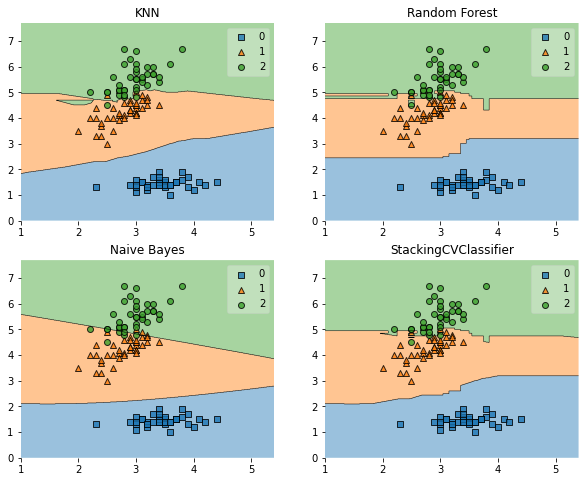

In [69]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=clf)
    plt.title(lab)
plt.show()

### 實際 fit model

In [68]:
from sklearn.metrics import accuracy_score
sclf.fit(X_train, y_train)
y_pred_meta_test = sclf.predict(X_test)

# 輸出元模型的預測結果
meta_model_accuracy = accuracy_score(y_test, y_pred_meta_test)
print("Accuracy:", meta_model_accuracy)

Accuracy: 0.9666666666666667
